In [1]:
import os
import sys
import csv
from urllib.request import urlretrieve
from zipfile import ZipFile
from pathlib import Path

# from tqdm import tqdm_notebook as tqdm
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from tqdm import tqdm

import nltk
from nltk.stem import PorterStemmer

import warnings
warnings.filterwarnings('ignore')

import sklearn
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics.scorer import check_scoring
from sklearn.metrics import roc_auc_score

import imblearn.under_sampling
import imblearn.over_sampling
import imblearn.pipeline

from IPython.display import display

In [2]:
import sys
sys.path.append('../')

from citation_sentiment_analysis.datasets.athar import (
    download_and_read_athar_txt_with_sentiment_label,
    filter_long_sentences_from_athar
)
from citation_sentiment_analysis.datasets.words_en import download_and_read_english_words
from citation_sentiment_analysis.preprocessing.token_filter import (
    get_default_words_to_include,
    keep_sentence_list_tokens_in,
    get_token_counts,
    drop_token_counts_not_in_top
)
from citation_sentiment_analysis.preprocessing.word_similarity import load_glove, most_similar
from citation_sentiment_analysis.preprocessing.simple_text import simplify_tokens
from citation_sentiment_analysis.utils.collection import iter_flatten
from citation_sentiment_analysis.utils.jupyter import printmd
from citation_sentiment_analysis.utils.pipeline import (
    create_pipelines,
    multi_pipeline_steps_cross_validate_scores
)
from citation_sentiment_analysis.utils.plot import bar_plot_with_numbers, configure_default_plot_style
from citation_sentiment_analysis.utils.string import lower_all
from citation_sentiment_analysis.utils.vectorizer import transform_to_counts

In [3]:
configure_default_plot_style()

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
athar_df = filter_long_sentences_from_athar(download_and_read_athar_txt_with_sentiment_label())
athar_df.head()

,source_paper_id,target_paper_id,sentiment,citation_text,sentiment_label
0,A00-1043,A00-2024,o,We analyzed a set of articles and identified s...,neutral
1,H05-1033,A00-2024,o,Table 3: Example compressions Compression AvgL...,neutral
2,I05-2009,A00-2024,o,5.3 Related works and discussion Our two-step ...,neutral
3,I05-2009,A00-2024,o,(1999) proposed a summarization system based o...,neutral
4,I05-2009,A00-2024,o,We found that the deletion of lead parts did n...,neutral


In [6]:
w2v = load_glove()
print('number of word vectors: %d (embedding size: %d, sample tokens: %s)' % (
    len(w2v), len(w2v.iloc[0]), w2v.index[:10].values
))
print(most_similar(w2v, 'however'))

number of word vectors: 400000 (embedding size: 50, sample tokens: ['the' ',' '.' 'of' 'to' 'and' 'in' 'a' '"' "'s"])
[('although', 0.9801390393473681), ('though', 0.9357160221673086), ('as', 0.9173495762573322), ('both', 0.9053673912921385), ('this', 0.905256886566932), ('but', 0.9050977636062989), ('be', 0.9030219190306548), ('also', 0.9024955114777448), ('latter', 0.8969175661233546), ('.', 0.8953238565845045)]


In [7]:
print(most_similar(w2v, 'however'))

[('although', 0.9801390393473681), ('though', 0.9357160221673086), ('as', 0.9173495762573322), ('both', 0.9053673912921385), ('this', 0.905256886566932), ('but', 0.9050977636062989), ('be', 0.9030219190306548), ('also', 0.9024955114777448), ('latter', 0.8969175661233546), ('.', 0.8953238565845045)]


In [8]:
words_to_include = get_default_words_to_include()

len(words_to_include)

109442

In [9]:
citation_texts = athar_df['citation_text']
# citation_texts = athar_balanced_df['citation_text']

citation_tokens = [nltk.word_tokenize(s) for s in citation_texts]
print('total tokens: %d, unique: %d' % (
    sum(len(tokens) for tokens in citation_tokens),
    len({t for tokens in citation_tokens for t in tokens})
))
print(citation_tokens[0][:20])

total tokens: 384256, unique: 19323
['We', 'analyzed', 'a', 'set', 'of', 'articles', 'and', 'identified', 'six', 'major', 'operations', 'that', 'can', 'be', 'used', 'for', 'editing', 'the', 'extracted', 'sentences']


In [10]:
citation_filtered_tokens = keep_sentence_list_tokens_in(citation_tokens, words_to_include)
print('total tokens: %d, unique: %d' % (
    sum(len(tokens) for tokens in citation_filtered_tokens),
    len({t for tokens in citation_filtered_tokens for t in tokens})
))
print(citation_filtered_tokens[0][:20])

total tokens: 169508, unique: 6205
['analyzed', 'set', 'articles', 'and', 'identified', 'six', 'major', 'operations', 'that', 'can', 'used', 'for', 'editing', 'the', 'extracted', 'sentences', 'including', 'removing', 'extraneous', 'phrases']


In [11]:
filtered_token_counts = get_token_counts(iter_flatten(citation_filtered_tokens))
display(filtered_token_counts.describe().to_frame('description'))
display(filtered_token_counts.tail(5).to_frame('count'))

,description
count,6205.000000
mean,27.317969
std,238.447123
min,1.000000
25%,1.000000
50%,3.000000
75%,12.000000
max,13249.000000


,count
token,
prerequisite,1
doubles,1
doubly,1
doubted,1
killed,1


In [12]:
print(list(simplify_tokens(['recruit'], filtered_token_counts, w2v)))
print(list(simplify_tokens(['however'], filtered_token_counts, w2v)))
print(list(simplify_tokens(['xyz'], filtered_token_counts, w2v)))
print(list(simplify_tokens(['subsequent'], filtered_token_counts, w2v)))
print(list(simplify_tokens(['abstractors'], filtered_token_counts, w2v)))

['recruiting']
['however']
['infinity']
['following']
['abstractors']


In [13]:
simplified_token_map = {
    token: simplified_token
    for token, simplified_token in zip(
        filtered_token_counts.index,
        list(simplify_tokens(filtered_token_counts.index, filtered_token_counts, w2v, progress=True))
    )
}
print(len(simplified_token_map))

6205                                                


In [14]:
citation_simplified_tokens = [
    [simplified_token_map.get(t, t) for t in tokens]
    for tokens in citation_filtered_tokens
]
print('total tokens: %d, unique: %d' % (
    sum(len(tokens) for tokens in citation_simplified_tokens),
    len({t for tokens in citation_simplified_tokens for t in tokens})
))
print(citation_simplified_tokens[0][:20])

total tokens: 169508, unique: 1341
['evaluated', 'set', 'articles', 'and', 'found', 'five', 'major', 'part', 'that', 'can', 'used', 'for', 'text', 'the', 'extracted', 'sentences', 'including', 'allow', 'correct', 'phrases']


In [15]:
ps = PorterStemmer()
citation_stemmed_tokens = [[ps.stem(t) for t in tokens] for tokens in citation_filtered_tokens]
print(citation_stemmed_tokens[0][:20])

['analyz', 'set', 'articl', 'and', 'identifi', 'six', 'major', 'oper', 'that', 'can', 'use', 'for', 'edit', 'the', 'extract', 'sentenc', 'includ', 'remov', 'extran', 'phrase']


In [16]:
ps = PorterStemmer()
citation_simplified_stemmed_tokens = [[ps.stem(t) for t in tokens] for tokens in citation_simplified_tokens]
print(citation_simplified_stemmed_tokens[0][:20])

['evalu', 'set', 'articl', 'and', 'found', 'five', 'major', 'part', 'that', 'can', 'use', 'for', 'text', 'the', 'extract', 'sentenc', 'includ', 'allow', 'correct', 'phrase']


,count,mean,std,min,25%,50%,75%,max
description,3617.0,46.864252,322.632801,1.0,1.0,5.0,21.0,13249.0


token,the,and,use,for,model,word,that,with,translat,are
most frequent,13249,10966,3511,3313,2965,1964,1739,1679,1661,1538


token,sport,malform,dollar,speedi,spectrum,malais,spearman,spear,mal,era
least frequent,1,1,1,1,1,1,1,1,1,1


token,evert,dia,cat,prefix,dimension,brook,oppos,hereaft,hall,sigmoid
less than 10,9,9,9,9,9,9,9,9,9,9


total number of tokens: 3617
number of tokens only appearing once: 928
number of tokens appearing less than 10 times: 2282


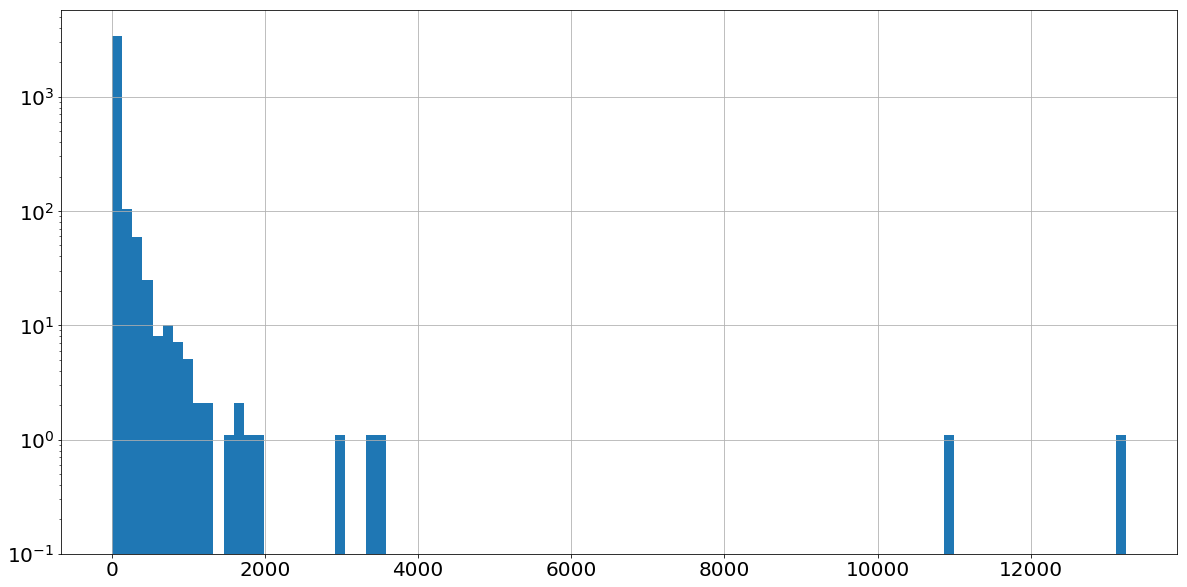

In [17]:
def show_token_count_stats(token_counts):
    display(token_counts.describe().to_frame('description').T)
    display(token_counts.head(10).to_frame('most frequent').T)
    display(token_counts.tail(10).to_frame('least frequent').T)
    display(token_counts[token_counts < 10].head(10).to_frame('less than 10').T)
    print('total number of tokens:', len(token_counts))
    print('number of tokens only appearing once:', sum(token_counts == 1))
    print('number of tokens appearing less than 10 times:', sum(token_counts < 10))

    fig, ax = plt.subplots()
    token_counts.hist(ax=ax, bins=100, bottom=0.1)
    ax.set_yscale('log')

token_counts = get_token_counts(iter_flatten(citation_stemmed_tokens))
show_token_count_stats(token_counts)

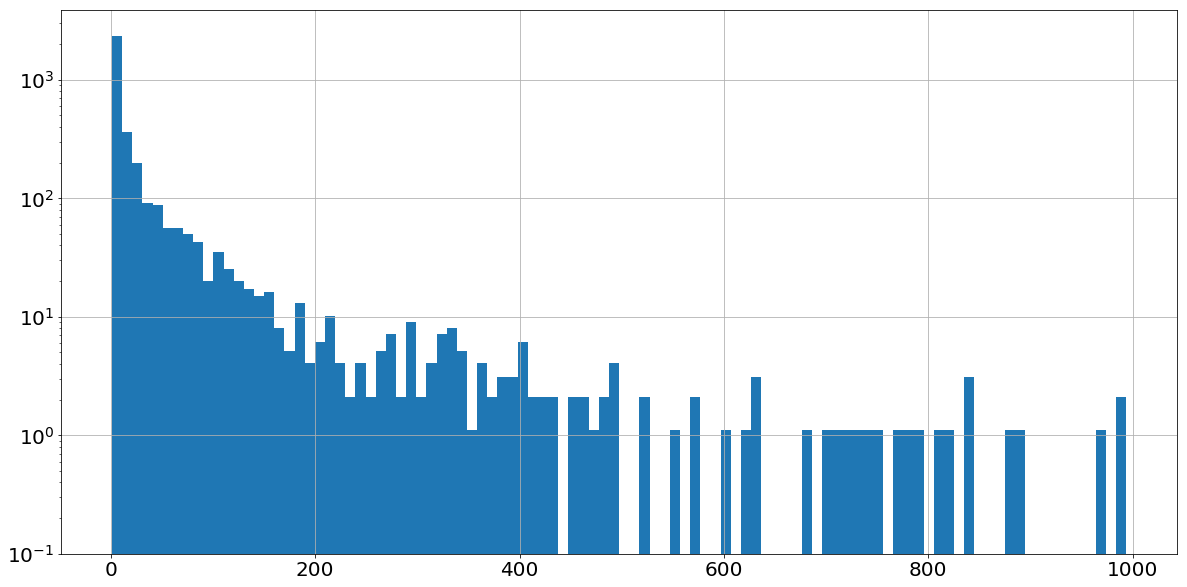

In [18]:
fig, ax = plt.subplots()
token_counts[token_counts < 1000].hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')

,count,mean,std,min,25%,50%,75%,max
description,1042.0,162.675624,594.772952,1.0,3.0,62.0,162.0,13249.0


token,the,and,use,for,model,word,that,translat,with,are
most frequent,13249,10993,3682,3339,3083,2006,1739,1687,1679,1538


token,pipag,pipe,pirat,pli,poller,porter,constel,poss,consecut,zen
least frequent,1,1,1,1,1,1,1,1,1,1


token,evert,appendix,abduct,pyramid,quat,rasp,synonymi,hereaft,lex,converg
less than 10,9,9,9,9,9,9,9,9,8,8


total number of tokens: 1042
number of tokens only appearing once: 181
number of tokens appearing less than 10 times: 345


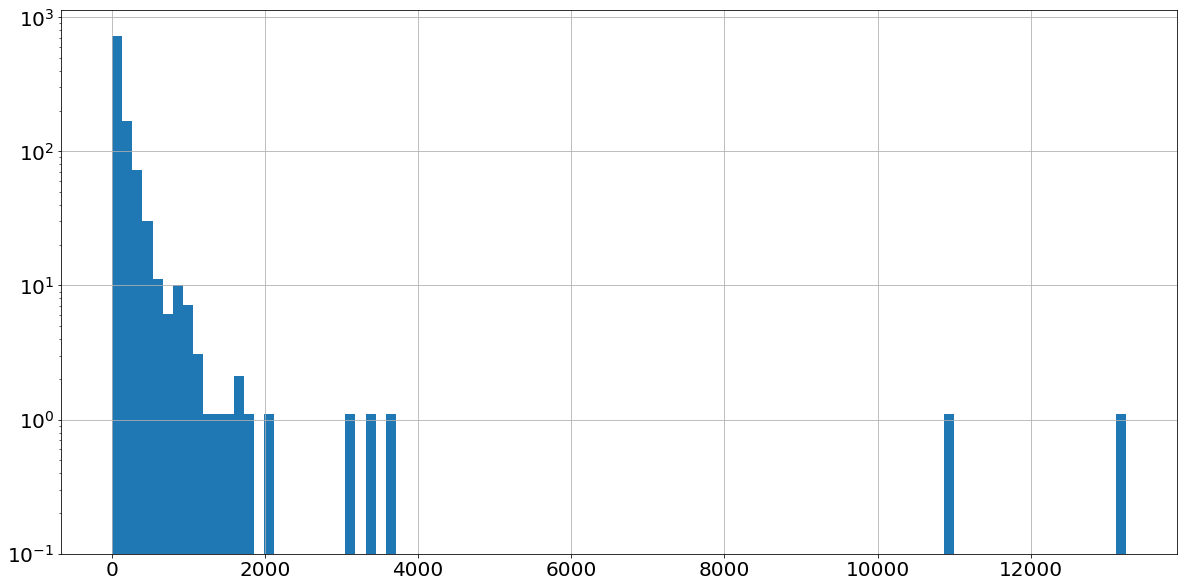

In [19]:
simplified_token_counts = get_token_counts(iter_flatten(citation_simplified_stemmed_tokens))
show_token_count_stats(simplified_token_counts)

In [20]:
X_all = transform_to_counts(citation_stemmed_tokens)
y_all = athar_df['sentiment'] == 'n'

print(X_all.shape)
print(y_all.shape)

(8699, 3617)
(8699,)


In [21]:
scores = cross_val_score(
    BernoulliNB(), X_all, y_all, cv=4, scoring='roc_auc'
)
print('roc_auc mean: %s, std: %s' % (scores.mean(), scores.std()))

roc_auc mean: 0.770593509736653, std: 0.0432709152384011


In [22]:
model = DecisionTreeClassifier()
model.fit(X_all, y_all)
f1_score(y_all, model.predict(X_all))

0.9513108614232211

In [23]:
default_samplers = [
    imblearn.over_sampling.RandomOverSampler(random_state=42),
    imblearn.under_sampling.RandomUnderSampler(random_state=42),
]

default_models = [
    BernoulliNB(),
    DecisionTreeClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
]

default_pipelines = create_pipelines([
    ('sampler', default_samplers),
    ('model', default_models)
])

In [24]:
printmd('## Generally filtered tokens')
multi_pipeline_steps_cross_validate_scores(
    default_pipelines,
    transform_to_counts(citation_stemmed_tokens), y_all,
    cv=KFold(n_splits=4, shuffle=True, random_state=42),
    scoring=('roc_auc', 'accuracy', 'f1', 'precision', 'recall')
).groupby(['sampler', 'model']).agg(['mean', 'std']).reset_index().sort_values(
    ('roc_auc', 'mean'), ascending=False
)

## Generally filtered tokens

X (8699, 3617) -> y (8699,)

sampler                   model  accuracy                  f1  \
                                                   mean       std      mean   
3  RandomUnderSampler             BernoulliNB  0.798022  0.009733  0.186017   
5  RandomUnderSampler  RandomForestClassifier  0.803425  0.033205  0.163542   
0   RandomOverSampler             BernoulliNB  0.922290  0.007719  0.263766   
2   RandomOverSampler  RandomForestClassifier  0.965973  0.003259  0.094665   
4  RandomUnderSampler  DecisionTreeClassifier  0.727668  0.016126  0.146738   
1   RandomOverSampler  DecisionTreeClassifier  0.924474  0.007744  0.194466   

            precision              recall             roc_auc            
        std      mean       std      mean       std      mean       std  
3  0.023907  0.106910  0.014694  0.720986  0.079838  0.824288  0.020029  
5  0.030584  0.095508  0.020272  0.588616  0.047324  0.784089  0.019967  
0  0.018087  0.191972  0.026684  0.436356  0.059194  0.772878  0.019128  
2  0.033336  0.325874  0.119525  0.055540  0.019516  0.761414  0.004964  
4  0.016373  0.081644  0.009640  0.733908  0.099518  0.730825  0.041008  
1  0.016241  0.150431  0.024687  0.284589  0.029595  0.615197  0.009309

In [25]:
printmd('## Top 100 tokens')
multi_pipeline_steps_cross_validate_scores(
    default_pipelines,
    drop_token_counts_not_in_top(transform_to_counts(
        citation_stemmed_tokens
    ), 100), y_all,
    cv=KFold(n_splits=4, shuffle=True, random_state=42),
    scoring=('roc_auc', 'accuracy', 'f1', 'precision', 'recall')
).groupby(['sampler', 'model']).agg(['mean', 'std']).reset_index().sort_values(
    ('roc_auc', 'mean'), ascending=False
)

## Top 100 tokens

X (8699, 100) -> y (8699,)

sampler                   model  accuracy                  f1  \
                                                   mean       std      mean   
0   RandomOverSampler             BernoulliNB  0.749396  0.012194  0.143024   
3  RandomUnderSampler             BernoulliNB  0.682147  0.020601  0.120707   
5  RandomUnderSampler  RandomForestClassifier  0.679391  0.020810  0.117464   
2   RandomOverSampler  RandomForestClassifier  0.961834  0.003958  0.061958   
4  RandomUnderSampler  DecisionTreeClassifier  0.603517  0.034377  0.098490   
1   RandomOverSampler  DecisionTreeClassifier  0.928497  0.005987  0.103496   

            precision              recall             roc_auc            
        std      mean       std      mean       std      mean       std  
0  0.016577  0.080482  0.010417  0.652414  0.054347  0.758290  0.016418  
3  0.013057  0.066340  0.007885  0.681971  0.074661  0.740386  0.030338  
5  0.018011  0.064592  0.011020  0.662326  0.038632  0.712363  0.026893  
2  0.008407  0.174053  0.092665  0.039254  0.005000  0.648997  0.021711  
4  0.010430  0.053188  0.006056  0.677630  0.086998  0.636568  0.027102  
1  0.035180  0.087843  0.030821  0.127812  0.043218  0.539748  0.024735

In [26]:
printmd('## Simplified tokens')
multi_pipeline_steps_cross_validate_scores(
    default_pipelines,
    transform_to_counts(citation_simplified_stemmed_tokens), y_all,
    cv=KFold(n_splits=4, shuffle=True, random_state=42),
    scoring=('roc_auc', 'accuracy', 'f1', 'precision', 'recall')
).groupby(['sampler', 'model']).agg(['mean', 'std']).reset_index().sort_values(
    ('roc_auc', 'mean'), ascending=False
)

## Simplified tokens

X (8699, 1042) -> y (8699,)

sampler                   model  accuracy                  f1  \
                                                   mean       std      mean   
3  RandomUnderSampler             BernoulliNB  0.759511  0.017811  0.162342   
0   RandomOverSampler             BernoulliNB  0.878722  0.011301  0.224094   
5  RandomUnderSampler  RandomForestClassifier  0.761809  0.027392  0.153122   
2   RandomOverSampler  RandomForestClassifier  0.964938  0.003064  0.098638   
4  RandomUnderSampler  DecisionTreeClassifier  0.687545  0.032738  0.132735   
1   RandomOverSampler  DecisionTreeClassifier  0.928612  0.003773  0.174619   

            precision              recall             roc_auc            
        std      mean       std      mean       std      mean       std  
3  0.022696  0.091529  0.013823  0.724905  0.065173  0.821032  0.026977  
0  0.035609  0.141924  0.026643  0.546805  0.089887  0.805516  0.013714  
5  0.012354  0.086603  0.007710  0.676163  0.115424  0.799807  0.031439  
2  0.042229  0.300000  0.169558  0.059566  0.024704  0.758906  0.041107  
4  0.007328  0.072913  0.004610  0.746299  0.059366  0.715964  0.031260  
1  0.017586  0.139863  0.020577  0.236300  0.024825  0.594096  0.010429

In [27]:
printmd('## Top 100 simplified tokens')
multi_pipeline_steps_cross_validate_scores(
    default_pipelines,
    drop_token_counts_not_in_top(transform_to_counts(
        citation_simplified_stemmed_tokens
    ), 100), y_all,
    cv=KFold(n_splits=4, shuffle=True, random_state=42),
    scoring=('roc_auc', 'accuracy', 'f1', 'precision', 'recall')
).groupby(['sampler', 'model']).agg(['mean', 'std']).reset_index().sort_values(
    ('roc_auc', 'mean'), ascending=False
)

## Top 100 simplified tokens

X (8699, 100) -> y (8699,)

sampler                   model  accuracy                  f1  \
                                                   mean       std      mean   
0   RandomOverSampler             BernoulliNB  0.749166  0.008814  0.137942   
3  RandomUnderSampler             BernoulliNB  0.687663  0.017573  0.119992   
5  RandomUnderSampler  RandomForestClassifier  0.682605  0.027250  0.119861   
2   RandomOverSampler  RandomForestClassifier  0.962639  0.002564  0.074318   
4  RandomUnderSampler  DecisionTreeClassifier  0.600758  0.028625  0.087355   
1   RandomOverSampler  DecisionTreeClassifier  0.928612  0.005085  0.118403   

            precision              recall             roc_auc            
        std      mean       std      mean       std      mean       std  
0  0.020146  0.077657  0.012270  0.625101  0.059425  0.765077  0.015423  
3  0.014428  0.066032  0.008498  0.664464  0.061817  0.750865  0.032419  
5  0.016828  0.065859  0.009823  0.671258  0.048423  0.720261  0.025113  
2  0.012500  0.194378  0.060817  0.047168  0.009823  0.647325  0.036498  
4  0.023646  0.047242  0.013196  0.586623  0.096523  0.592585  0.046114  
1  0.018103  0.098699  0.019144  0.149212  0.016538  0.551805  0.007862

In [28]:
printmd('## Top 100 simplified tokens (not stemmed)')
multi_pipeline_steps_cross_validate_scores(
    default_pipelines,
    drop_token_counts_not_in_top(transform_to_counts(
        citation_simplified_tokens
    ), 100), y_all,
    cv=KFold(n_splits=4, shuffle=True, random_state=42),
    scoring=('roc_auc', 'accuracy', 'f1', 'precision', 'recall')
).groupby(['sampler', 'model']).agg(['mean', 'std']).reset_index().sort_values(
    ('roc_auc', 'mean'), ascending=False
)

## Top 100 simplified tokens (not stemmed)

X (8699, 100) -> y (8699,)

sampler                   model  accuracy                  f1  \
                                                   mean       std      mean   
0   RandomOverSampler             BernoulliNB  0.771353  0.013045  0.151838   
3  RandomUnderSampler             BernoulliNB  0.727899  0.012197  0.138796   
5  RandomUnderSampler  RandomForestClassifier  0.689274  0.018019  0.119648   
2   RandomOverSampler  RandomForestClassifier  0.959535  0.005135  0.066198   
4  RandomUnderSampler  DecisionTreeClassifier  0.593972  0.023148  0.091219   
1   RandomOverSampler  DecisionTreeClassifier  0.931832  0.004087  0.121791   

            precision              recall             roc_auc            
        std      mean       std      mean       std      mean       std  
0  0.030162  0.086454  0.018472  0.635153  0.085004  0.764550  0.024135  
3  0.019128  0.077374  0.011508  0.684878  0.082602  0.757114  0.047379  
5  0.016595  0.065920  0.009799  0.658435  0.071850  0.733126  0.047011  
2  0.030362  0.143317  0.096919  0.044613  0.019721  0.681172  0.010713  
4  0.007481  0.049158  0.004316  0.636344  0.037906  0.609464  0.017980  
1  0.026075  0.107451  0.036342  0.146969  0.025660  0.551154  0.012377

In [29]:
printmd('## Top 100 simplified tokens (SVC)')
multi_pipeline_steps_cross_validate_scores(
    create_pipelines([
        ('sampler', default_samplers),
        ('model', [
            BernoulliNB(),
            DecisionTreeClassifier(random_state=42),
            SVC(random_state=42),
        ])
    ]),
    drop_token_counts_not_in_top(transform_to_counts(
        citation_simplified_stemmed_tokens
    ), 100), y_all,
    cv=KFold(n_splits=4, shuffle=True, random_state=42),
    scoring=('roc_auc', 'accuracy', 'f1', 'precision', 'recall')
).groupby(['sampler', 'model']).agg(['mean', 'std']).reset_index().sort_values(
    ('roc_auc', 'mean'), ascending=False
)

## Top 100 simplified tokens (SVC)

X (8699, 100) -> y (8699,)

sampler                   model  accuracy                  f1  \
                                                   mean       std      mean   
2   RandomOverSampler                     SVC  0.810897  0.007852  0.160991   
0   RandomOverSampler             BernoulliNB  0.749166  0.008814  0.137942   
3  RandomUnderSampler             BernoulliNB  0.687663  0.017573  0.119992   
5  RandomUnderSampler                     SVC  0.712493  0.041683  0.116173   
4  RandomUnderSampler  DecisionTreeClassifier  0.600758  0.028625  0.087355   
1   RandomOverSampler  DecisionTreeClassifier  0.928612  0.005085  0.118403   

            precision              recall             roc_auc            
        std      mean       std      mean       std      mean       std  
2  0.022124  0.094039  0.014167  0.567218  0.074133  0.767412  0.016655  
0  0.020146  0.077657  0.012270  0.625101  0.059425  0.765077  0.015423  
3  0.014428  0.066032  0.008498  0.664464  0.061817  0.750865  0.032419  
5  0.017459  0.064686  0.010538  0.584275  0.063375  0.719279  0.019105  
4  0.023646  0.047242  0.013196  0.586623  0.096523  0.592585  0.046114  
1  0.018103  0.098699  0.019144  0.149212  0.016538  0.551805  0.007862

In [30]:
sequence_lengths = pd.Series([len(s) for s in citation_tokens])
printmd('Longer than **100** tokens: **%s**' % sum(sequence_lengths > 100))
printmd('Longer than **1000** tokens: **%s**' % sum(sequence_lengths > 1000))
sequence_lengths.describe().to_frame('num tokens').T

Longer than **100** tokens: **358**

Longer than **1000** tokens: **0**

,count,mean,std,min,25%,50%,75%,max
num tokens,8699.0,44.172434,26.031167,4.0,28.0,38.0,53.0,286.0


In [31]:
# X_sampled, y_sampled = imblearn.under_sampling.RandomUnderSampler().fit_sample(
#     X_train, y_train
# )

sentence_list = citation_stemmed_tokens

X_train, X_test, y_train, y_test, athar_train_df, athar_test_df = train_test_split(drop_token_counts_not_in_top(
    transform_to_counts(
        sentence_list
    ), 2000
), y_all, athar_df, shuffle=True, test_size=0.5, stratify=None)

# X_train_sampled, y_train_sampled = imblearn.over_sampling.RandomOverSampler().fit_sample(
#     X_train, y_train
# )

X_train_sampled, y_train_sampled = imblearn.under_sampling.RandomUnderSampler().fit_sample(
    X_train, y_train
)

X_test_sampled, y_test_sampled, X_test_sampled_indices = imblearn.under_sampling.RandomUnderSampler(
    return_indices=True
).fit_sample(X_test, y_test)

model = BernoulliNB()
model.fit(X_train_sampled, y_train_sampled)
y_pred = model.predict(X_test_sampled)
f1_score(y_test_sampled, y_pred)

0.7819548872180451

In [32]:
y_pred_proba = model.predict_proba(X_test_sampled)
y_incorrect_mask = y_pred != y_test_sampled
athar_test_sampled_df = athar_test_df.iloc[X_test_sampled_indices]

In [33]:
def show_sentence_results(mask, title):
    df = athar_test_sampled_df[mask]
    printmd('## %s\n\n %s' % (title, '\n\n'.join(
        '> **(sentiment: %s, y_test: %s, y_pred: %s, y_proba: %s)**: %s' % (
            sentiment, _y_test, _y_pred, _y_proba, s
        )
        for s, sentiment, _y_test, _y_pred, _y_proba in zip(
            df['citation_text'], df['sentiment'], y_test_sampled[mask], y_pred[mask], y_pred_proba[mask]
        )
    )))

show_sentence_results(y_incorrect_mask & (~y_pred), "Wrongly classified as non-negative")

## Wrongly classified as non-negative

 > **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.81265585 0.18734415])**: For example, 10 million words of the American National Corpus (Ide et al. , 2002) will have manually corrected POS tags, a tenfold increase over the Penn Treebank (Marcus et al. , 1993), currently used for training POS taggers.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.94784872 0.05215128])**: While both (Johnson, 2001) and (Klein and Manning, 2002) propose models which use the parameters of the generative model but train to optimize a discriminative criteria, neither proposes training algorithms which are computationally tractable enough to be used for broad coverage parsing.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.79475429 0.20524571])**: The size of the development set used to generate 1 and 2 (1000 sentences) compensates the tendency of the unsmoothed MERT algorithm to overfit (Och, 2003) by providing a high ratio between number of variables and number of parameters to be estimated.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.80222276 0.19777724])**: 2This can explain why previous attempts to use WordNet for generating sentence-level paraphrases (Barzilay and Lee, 2003; Quirk et al. , 2004) were unsuccessful.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.84228409 0.15771591])**: String alignment with synchronous grammars is quite expensive even for simple synchronous formalisms like ITG (Wu, 1997)but Duchi et al.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.57259307 0.42740693])**: 2 2.1 Word Alignment Adaptation Bi-directional Word Alignment In statistical translation models (Brown et al. , 1993), only one-to-one and more-to-one word alignment links can be found.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.68283011 0.31716989])**: Despite ME theory and its related training algorithm (Darroch and Ratcliff, 1972) do not set restrictions on the range of feature functions1, popular NLP text books (Manning and Schutze, 1999) and research papers (Berger et al. , 1996) seem to limit them to binary features.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.99085268 0.00914732])**: Hanks and Church (1990) proposed using pointwise mutual information to identify collocations in lexicography; however, the method may result in unacceptable collocations for low-count pairs.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.89998442 0.10001558])**: Point-wise mutual information (PMI) is commonly used for computing the association of two terms (e.g., Turney 2002), which is defined as: nullnullnull null null,null null nullnullnull nullnullnullnull,nullnull nullnull null null null nullnullnullnullnull . However, we argue that PMI is not a suitable measure for our purpose.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.71942301 0.28057699])**: Although, there are various manual/automatic evaluation methods for these systems, e.g., BLEU (Papineni et al. 2002), these methods are basically incapable of dealing with an MTsystem and a w/p-MT-system at the same time, as they have different output forms.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.53537149 0.46462851])**: While SCL has been successfully applied to PoS tagging and Sentiment Analysis (Blitzer et al., 2006; Blitzer et al., 2007), its effectiveness for parsing was rather unexplored.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.63959967 0.36040033])**: The program takes the output of char_align (Church, 1993), a robust alternative to sentence-based alignment programs, and applies word-level constraints using a version of Brown el al.'s Model 2 (Brown et al. , 1993), modified and extended to deal with robustness issues.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.99327606 0.00672394])**: Unlike Church and Hanks (1990), Smadja (1993) goes beyond the "two-word" limitation and deals with "collocations of arbitrary length".

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.7768653 0.2231347])**: Though taggers based on dependency networks (Toutanova et al. , 2003), SVM (Gimenez and M`arquez, 2003), MaxEnt (Ratnaparkhi, 1996), CRF (Smith et al. , 2005), and other methods may reach slightly better results, their train/test cycle is orders of magnitude longer.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [9.99893023e-01 1.06977080e-04])**: In the thriving area of research on automatic analysis and processing of product reviews (Hu and Liu 2004; Turney 2002; Pang and Lee 2005), little attention has been paid to the important task studied here  assessing review helpfulness.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.78456966 0.21543034])**: Our system improves over the latent named-entity tagging in Haghighi and Klein (2007), from 61% to 87%.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.80515402 0.19484598])**: three models in (Collins, 1997) are susceptible to the O(n 3) method (cf.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.67120133 0.32879867])**: In addition, the clustering methods used, such as HMMs and Browns algorithm (Brown et al., 1992), seem unable to adequately capture the semantics of MNs since they are based only on the information of adjacent words.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.51522833 0.48477167])**: Unfortunately, this is not the case for such widely used MT evaluation metrics as BLEU (Papineni et al. , 2002) and NIST (Doddington, 2002).

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.52726732 0.47273268])**: We want to note that our WordNetbased method outperforms that of Hughes and Ramage (2007), which uses a similar method.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.9598111 0.0401889])**: Many approaches for POS tagging have been developed in the past, including rule-based tagging (Brill, 1995), HMM taggers (Brants, 2000; Cutting and others, 1992), maximum-entropy models (Rathnaparki, 1996), cyclic dependency networks (Toutanova et al. , 2003), memory-based learning (Daelemans et al. , 1996), etc. All of these approaches require either a large amount of annotated training data (for supervised tagging) or a lexicon listing all possible tags for each word (for unsupervised tagging).

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [9.99537844e-01 4.62156400e-04])**: 2 Previous work on Sentiment Analysis Some prior studies on sentiment analysis focused on the document-level classification of sentiment (Turney, 2002; Pang et al. , 2002) where a document is assumed to have only a single sentiment, thus these studies are not applicable to our goal.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.52396767 0.47603233])**: As one can see in Table 4, the resulting parser ranks among the best lexicalized parsers, beating those of Collins (1999) and Charniak and Johnson (2005).8 Its F1 performance is a 27% reduction in error over Matsuzaki et al.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.91091138 0.08908862])**: a time-consuming process (Litman and Pan, 2002; Marcus et al. , 1993; Xia et al. , 2000; Wiebe, 2002).

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.76387747 0.23612253])**: Experiments, by using 4 algorithms and through visualization techniques, revealed that clustering is a worthless effort for paraphrase corpora construction, contrary to the literature claims (Barzilay & Lee, 2003).

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.83552395 0.16447605])**: Thirdly, (Shen et al., 2008) deploys the dependency language model to augment the lexical language model probability be1183 tween two head words but never seek a full dependency graph.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.50263089 0.49736911])**: 13Huang and Chiang (2007) give an informal example, but do not elaborate on it.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.82738147 0.17261853])**: Secondly, while most pronoun resolution evaluations simply exclude non-referential pronouns, recent unsupervised approaches (Cherry and Bergsma, 2005; Haghighi and Klein, 2007) must deal with all pronouns in unrestricted text, and therefore need robust modules to automatically handle non-referential instances.

> **(sentiment: n, y_test: True, y_pred: False, y_proba: [0.98595971 0.01404029])**: Some are the result of inconsistency in labeling in the training data (Ratnaparkhi 1996), which usually reflects a lack of linguistic clarity or determination of the correct part of speech in context.

In [34]:
show_sentence_results(y_incorrect_mask & (y_pred), "Wrongly classified as negative")

## Wrongly classified as negative

 > **(sentiment: o, y_test: False, y_pred: True, y_proba: [2.26526774e-05 9.99977347e-01])**: 1 Introduction With the introduction of the BLEU metric for machine translation evaluation (Papineni et al, 2002), the advantages of doing automatic evaluation for various NLP applications have become increasingly appreciated: they allow for faster implement-evaluate cycles (by by-passing the human evaluation bottleneck), less variation in evaluation performance due to errors in human assessor judgment, and, not least, the possibility of hill-climbing on such metrics in order to improve system performance (Och 2003).

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.4697319 0.5302681])**: For example, Och (2003) shows how to train a log-linear translation model not by maximizing the likelihood of training data, but maximizing the BLEU score (among other metrics) of the model on 53 the data.

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.05859391 0.94140609])**: We use these tuples to calculate a balanced f-score against the gold alignment tuples.4 Method Dict size f-score Gold 28 100.0 Monotone 39 68.9 IBM-1 (Brown et al., 1993) 30 80.3 IBM-4 (Brown et al., 1993) 29 86.9 IP 28 95.9 The last line shows an average f-score over the 8 tied IP solutions.

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.00255489 0.99744511])**: But it makes obvious that (Ratnaparkhi et al. , 1994) were tackling a problem different from (Hindle and Rooth, 1993) given the fact that their baseline was at 59% guessing noun attachment (rather than 67% in the Hindle and Rooth experiments).3 Of course, the baseline is not a direct indicator of the difficulty of the disambiguation task.

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.00207783 0.99792217])**: 2.2 Motivation from previous work 2.2.1 Parsing In recent years, the success of statistical parsing techniques can be attributed to several factors, such as the increasing size of computing machinery to accommodate larger models, the availability of resources such as the Penn Treebank (Marcus et al. , 1993) and the success of machine learning techniques for lowerlevel NLP problems, such as part-of-speech tagging (Church, 1988; Brill, 1995), and PPattachment (Brill and Resnik, 1994; Collins and Brooks, 1995).

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.06248496 0.93751504])**: This conclusion is supported by the fact that true IMT is not, to our knowledge, used in most modern translator's support environments, eg (Eurolang, 1995; I,'rederking et al. , 1993; IBM, 1995; Kugler et al. , 1991; Nirenburg, 1992; ~li'ados, 1995).

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.05155851 0.94844149])**: The word alignment used in GHKM is usually computed independent ofthesyntacticstructure,andasDeNeroandKlein (2007) and May and Knight (2007) have noted, Ch-En En-Ch Union Heuristic 28.6% 33.0% 45.9% 20.1% Table 1: Percentage of corpus used to generate big templates, based on different word alignments 9-12 13-20 21 Ch-En 18.2% 17.4% 64.4% En-Ch 15.9% 20.7% 63.4% Union 9.8% 15.1% 75.1% Heuristic 24.6% 27.9% 47.5% Table 2: In the selected big templates, the distribution of words in the templates of different sizes, which are measured based on the number of symbols in their RHSs is not the best for SSMT systems.

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.05235738 0.94764262])**: 2 The IBM Model 4 For the work described in this paper we used a modified version of the statistical machine translation tool developed in the context of the 1999 Johns HopkinsSummer Workshop (Al-Onaizan et al. , 1999), which implements IBM translation model 4 (Brown et al. , 1993).

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.1137113 0.8862887])**: (Brown et al. , 1993) introduced five statistical translation models (IBM Models 1  5).

> **(sentiment: p, y_test: False, y_pred: True, y_proba: [0.0099606 0.9900394])**: In particular, we have implemented an unsupervised morphological analyzer that outperforms Goldsmith s (2001) Linguistica and Creutz and Lagus s (2005) Morfessor for our English and Bengali datasets and compares favorably to the bestperforming morphological parsers in MorphoChallenge 20053 (see Dasgupta and Ng (2007)).

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.03591034 0.96408966])**: Expectation Maximization does surprisingly well on larger data sets and is competitive with the Bayesian estimators at least in terms of cross-validation accuracy, confirming the results reported by Johnson (2007).

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.10132082 0.89867918])**: Furthermore, I plan to apply my parsers in other domains (e.g. , biomedical data) (Blitzer et al. , 2006) besides treebank data, to investigate the effectiveness and generality of my approaches.

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.34067845 0.65932155])**: The trends are the same as in (McClosky et al. , 2006): Adding NANC data improves parsing performance on BROWN development considerably, improving the f-score from 83.9% to 86.4%.

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.43618611 0.56381389])**: Some of the alignment sets also have links which are not Sure links but are Possible links (Och and Ney 2003).

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.00384115 0.99615885])**: Our experimental results display that our SDB model achieves a substantial improvement over the baseline and significantly outperforms XP+ according to the BLEU metric (Papineni et al., 2002).

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.49058412 0.50941588])**: 2 Background: Overview of BLEU This section briefly describes the original BLEU (Papineni et al. , 2002b)1, which was designed for English translation evaluation, so English sentences are used as examples in this section.

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.03813847 0.96186153])**: But because we want the insertion state a1a16a20 to model digressions or unseen topics, we take the novel step of forcing its language model to be complementary to those of the other states by setting a2 a3a27a38 a21 a8 a8 a4 a8 a24 a26a11a28a30a29a6 a39a41a40a43a42a45a44a16a46 a1a48a47a1a50a49 a20 a2 a3 a26a17a21 a8a9a8 a4 a8 a24 a51a53a52a55a54a57a56 a21 a39a58a40a43a42a45a44a16a46 a1a59a47a1a50a49 a20 a2 a3a27a26a11a21a50a60 a4 a8 a24a30a24 a17 4Following Barzilay and Lee (2003), proper names, numbers and dates are (temporarily) replaced with generic tokens to help ensure that clusters contain sentences describing the same event type, rather than same actual event.

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.18880003 0.81119997])**: (2003), a trigram target language model, an order model, word count, phrase count, average phrase size functions, and whole-sentence IBM Model 1 logprobabilities in both directions (Och et al. 2004).

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.18875035 0.81124965])**: Whereas Ratnaparkhi (1996) used feature support cutoffs and early stopping to stop overfitting of the model, and Collins (2002) contends that including low support features harms a maximum entropy model, our results show that low support features are useful in a regularized maximum entropy model.

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.49677433 0.50322567])**: Following previous work in statistical MT (Brown et al., 1993), we envision a noisy-channel model in which a language model generates English, and then a translation model transforms English trees into Chinese.

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.18634208 0.81365792])**: Dialogs Speakers Turns Words Fragments Distinct Words Distinct Words/POS Singleton Words Singleton Words/POS Intonational Phrases Speech Repairs 98 34 6163 58298 756 859 1101 252 350 10947 2396 Table 1: Size of the Trains Corpus 2.1 POS Annotations Our POS tagset is based on the Penn Treebank tagset (Marcus et al. , 1993), but modified to include tags for discourse markers and end-of-turns, and to provide richer syntactic information (Heeman, 1997).

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.29114584 0.70885416])**: First, we need to determine whether or not the positive effect of SVD feature selection is preserved in more complex feature spaces such as syntactic feature spaces as those used in (Snow et al., 2006).

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.34502358 0.65497642])**: These joint counts are estimated using the phrase induction algorithm described in (Koehn et al. , 2003), with symmetrized word alignments generated using IBM model 2 (Brown et al. , 1993).

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.01502846 0.98497154])**: (1997), Johnson (1998)--that conditioning the probabilities of structures on the context within which they appear, for example on the lexical head of a constituent (Charniak 1997; Collins 1997), on the label of its parent nonterrninal (Johnson 1998), or, ideally, on both and many other things besides, leads to a much better parsing model and results in higher parsing accuracies.

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.49836264 0.50163736])**: Some existing resources contain lists of subjective words (e.g. , Levins desire verbs (1993)), and some empirical methods in NLP have automatically identified adjectives, verbs, and N-grams that are statistically associated with subjective language (e.g. , (Turney, 2002; Hatzivassiloglou and McKeown, 1997; Wiebe, 2000; Wiebe et al. , 2001)).

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.30084391 0.69915609])**: 8This result is presented as 0.053 with the official ROUGE scorer (Lin, 2004).

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.48103389 0.51896611])**: Wu (1997)s Inversion Transduction Grammar, as well as tree-transformation models of translation such as Yamada and Knight (2001), Galley et al.

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.23058278 0.76941722])**: In many cases, improving semi-supervised models was done by seeding these models with domain information taken from dictionaries or ontology (Cohen and Sarawagi, 2004; Collins and Singer, 1999; Haghighi and Klein, 2006; Thelen and Riloff, 2002).

> **(sentiment: o, y_test: False, y_pred: True, y_proba: [0.27900263 0.72099737])**: Therefore, other machine learning techniques such as perceptron (Collins, 2002) could also be applied for this problem.